In [1]:
#Step 1: Import the basic libraries and parse the data and save it as a df


import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd

# Replace this path with your export.xml location
xml_file = "/Users/vaswatihazarika/Downloads/apple_health_export/export.xml"

print("Parsing Apple Health export...")

tree = ET.parse(xml_file)
root = tree.getroot()

# Dictionary to sum steps per day
steps_per_day = defaultdict(int)

for record in root.findall('Record'):
    if record.attrib.get('type') == 'HKQuantityTypeIdentifierStepCount':
        # Start and end dates look like '2025-07-20 12:00:00 +0000'
        start_date = record.attrib.get('startDate').split(' ')[0]
        step_count = int(float(record.attrib.get('value')))
        steps_per_day[start_date] += step_count

# Convert to DataFrame
df_steps = pd.DataFrame([
    {'date': date, 'steps': steps} 
    for date, steps in steps_per_day.items()
])

# Sort by date
df_steps['date'] = pd.to_datetime(df_steps['date'])
df_steps = df_steps.sort_values('date')

# Save to CSV
df_steps.to_csv('/Users/vaswatihazarika/Downloads/apple_watch_steps.csv', index=False)
print("Saved daily steps to apple_watch_steps.csv")


Parsing Apple Health export...
Saved daily steps to apple_watch_steps.csv


#Step 1.a : Check the structure of your data

In [3]:
df_steps.head()

,date,steps
1002,2021-05-07,339
1003,2021-05-08,1138
1004,2021-05-09,1699
1005,2021-05-10,1080
1006,2021-05-11,1316


In [5]:
#Step 1.b Data Wrangling : convert the date to date time

df_steps['date'] = pd.to_datetime(df_steps['date'])
df_steps = df_steps.sort_values('date')
df_steps.head()

,date,steps
1002,2021-05-07,339
1003,2021-05-08,1138
1004,2021-05-09,1699
1005,2021-05-10,1080
1006,2021-05-11,1316


In [9]:
#Step 1c : import libaries

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
corr_matrix = df_steps.corr()

plt.show()
corr_matrix

<Figure size 2000x2000 with 0 Axes>

,date,steps
date,1.000000,0.476021
steps,0.476021,1.000000


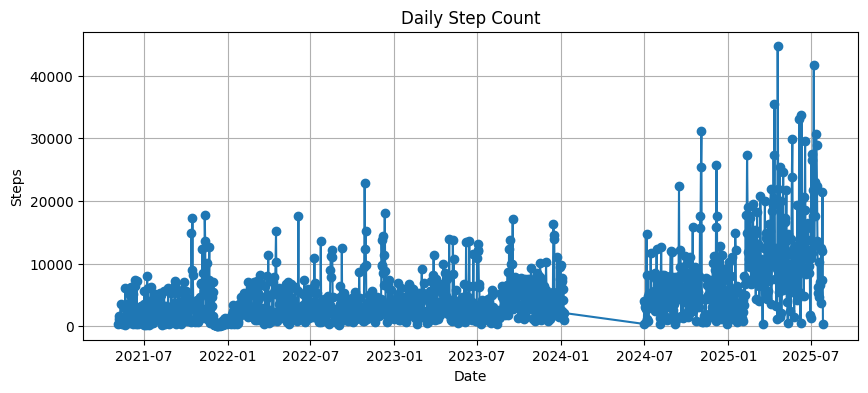

In [21]:
#Step 2.a : Basic EDA to see the data pre-processing

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df_steps['date'], df_steps['steps'], marker='o')
plt.title("Daily Step Count")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.grid(True)
plt.show()


In [23]:
# Step 2.b Check for missing dates and fill

df_steps['date'] = pd.to_datetime(df_steps['date'])
df_steps = df_steps.set_index('date').sort_index()
all_days = pd.date_range(df_steps.index.min(), df_steps.index.max())
df_steps = df_steps.reindex(all_days, fill_value=0)
df_steps.rename_axis('date', inplace=True)

print(df_steps.head())


            steps
date             
2021-05-07    339
2021-05-08   1138
2021-05-09   1699
2021-05-10   1080
2021-05-11   1316


In [25]:
X =df_steps[['steps']]
X.shape

(1543, 1)

#Testing : we will run nearest neighbours to see with Hopkins test if this is good for clustering

In [27]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    n = len(X) 
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0
 
    return H

hopkins(X)

np.float64(0.9890796324209167)

The Hopkins score show that 0.98 is high meaning the data is clustered and using clustering is a good first step

In [33]:
#Step 3.a Model evaluation : we will use kmeans model at first to see if it can best fit the data

scaler = StandardScaler()
X_scaled =  scaler.fit_transform(X)
X_scaled
X_scaled_df = pd.DataFrame(X_scaled)
X_scaled_df.columns = ['steps']
X_scaled_df

,steps
0,-0.810182
1,-0.654327
2,-0.544898
3,-0.665641
4,-0.619606
...,...
1538,1.565089
1539,1.463657
1540,0.578075
1541,3.294120


#The number of clusters best suited for this model can not eb arbitrary which is why we will use the elbow curve to identify how many clusters best fit the model

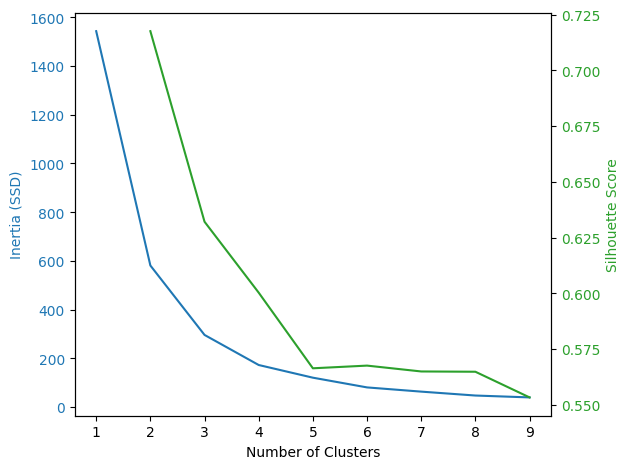

In [37]:
from sklearn.metrics import silhouette_score

ssd = []
sil_scores = []
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled_df)
    
    # Inertia (SSD)
    ssd.append(kmeans.inertia_)
    
    # Silhouette Score (excluding 1 cluster because silhouette score is not defined for 1 cluster)
    if num_clusters > 1:
        sil_score = silhouette_score(X_scaled_df, kmeans.labels_)
        sil_scores.append(sil_score)
    else:
        sil_scores.append(None)

# Plotting both Inertia and Silhouette Score
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia (SSD)', color='tab:blue')
ax1.plot(range_n_clusters, ssd, color='tab:blue', label='Inertia (SSD)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Silhouette Score', color='tab:green')  # we already handled x-label with ax1
ax2.plot(range_n_clusters[1:], sil_scores[1:], color='tab:green', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()  # to ensure everything fits without overlap
plt.show()


In [39]:
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled_df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_scaled_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7161633805973393
For n_clusters=3, the silhouette score is 0.6266233221556231
For n_clusters=4, the silhouette score is 0.6002685116073525
For n_clusters=5, the silhouette score is 0.5652583747389283
For n_clusters=6, the silhouette score is 0.5672578491341691
For n_clusters=7, the silhouette score is 0.5626329604790806
For n_clusters=8, the silhouette score is 0.5639496071279495
For n_clusters=9, the silhouette score is 0.5482478680389069


The silhouette score ranges from -1 to +1.

A score close to +1 indicates that the data points are well clustered, meaning each point is close to the center of its assigned cluster and far from other clusters.
A score close to 0 suggests that the data points are on or near the decision boundary between clusters, making it harder to clearly distinguish the clusters.
A score close to -1 indicates that the data points might be wrongly clustered, as they are closer to a neighboring cluster than to their own.

We will choose 4 clusters as that is where the elbow starts to curve and the sillehoute score is good at 3.

In [45]:
#Fit clustering models 

kmeans = KMeans(n_clusters=4, max_iter=100)
kmeans.fit(X_scaled_df)

df_steps['cluster_id'] = kmeans.labels_
df_steps.head()



,steps,cluster_id
date,,
2021-05-07,339,3
2021-05-08,1138,3
2021-05-09,1699,3
2021-05-10,1080,3
2021-05-11,1316,3


In [47]:
df_steps['cluster_id'].value_counts(normalize =True)

cluster_id
3    0.556708
1    0.316267
0    0.101750
2    0.025275
Name: proportion, dtype: float64

In [49]:
avg_steps_per_cluster = df_steps.groupby('cluster_id')['steps'].mean()

print(avg_steps_per_cluster)

cluster_id
0    12524.751592
1     5627.217213
2    25480.974359
3     1426.816065
Name: steps, dtype: float64


In [51]:
cluster_names = {
    0: "Highly Active",  # For the cluster with 12524.75 average steps
    1: "Moderately Active",  # For the cluster with 5627.22 average steps
    2: "Super Active",  # For the cluster with 25480.97 average steps
    3: "Sedentary"  # For the cluster with 1426.82 average steps
}

# Map cluster names to each row in the dataframe based on the cluster_id
df_steps['cluster_name'] = df_steps['cluster_id'].map(cluster_names)

# Now you have a new column 'cluster_name' in your dataframe
print(df_steps[['cluster_id', 'cluster_name', 'steps']].head())

            cluster_id cluster_name  steps
date                                      
2021-05-07           3    Sedentary    339
2021-05-08           3    Sedentary   1138
2021-05-09           3    Sedentary   1699
2021-05-10           3    Sedentary   1080
2021-05-11           3    Sedentary   1316


#Results: We created 4 clusters to cluster my walking behaviour